# พลอตแผนที่ภูมิอากาศ อุณหภูมิ Geopotential Height และลม ที่ระดับ 850 hPa
* โค้ดดัดแปลงมาจากลิงก์ https://unidata.github.io/python-gallery/examples/850hPa_TMPC_Winds.html

### ยูทูปชาแนลและแหล่งเรียนรู้ออนไลน์ที่นิสิตควรศึกษาทางด้านบรรยากาศศาสตร์ ได้แก่
    * Dr.kevin Perry จากมหาวิทยาลัย Utah สอนเรื่องบรรยากาศศาสตร์ https://www.youtube.com/channel/UCktw_bKshmipG9QH_pgMkLw/videos
    * Prof.Dr.Ronald Smith จากมหาวิทยาลัยYale เรื่องThe Atmosphere, the Ocean, and Environmental Change https://oyc.yale.edu/geology-and-geophysics/gg-140
    * หนังสือฟรี อุตุนิยมวิทยาภาคปฏิบัติ สอนการคำนวณของ Prof.Roland Stull https://www.eoas.ubc.ca/books/Practical_Meteorology/

In [1]:
from datetime import datetime

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
from metpy.units import units
import numpy as np
from scipy.ndimage import gaussian_filter
import xarray as xr


## 1. อ่านไลบราลี


In [2]:
ds = xr.open_dataset('era5_monthly_mean_globe.nc')
ds

<xarray.Dataset>
Dimensions:    (longitude: 1440, latitude: 721, time: 80)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 1981-01-01 1981-07-01 ... 2020-07-01
Data variables:
    z          (time, latitude, longitude) float32 ...
    r          (time, latitude, longitude) float32 ...
    t          (time, latitude, longitude) float32 ...
    u          (time, latitude, longitude) float32 ...
    v          (time, latitude, longitude) float32 ...
    vo         (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2022-04-07 04:35:51 GMT by grib_to_netcdf-2.24.3: /opt/ecmw...

## 2.เลือกวันเวลาที่ต้องการ

In [3]:
df = ds.sel(time='2011-01-01')

In [4]:
df

<xarray.Dataset>
Dimensions:    (longitude: 1440, latitude: 721)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
    time       datetime64[ns] 2011-01-01
Data variables:
    z          (latitude, longitude) float32 ...
    r          (latitude, longitude) float32 ...
    t          (latitude, longitude) float32 ...
    u          (latitude, longitude) float32 ...
    v          (latitude, longitude) float32 ...
    vo         (latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2022-04-07 04:35:51 GMT by grib_to_netcdf-2.24.3: /opt/ecmw...

## 3.เก็บค่าตัวแปรที่ต้องการนำไปใช้งาน


In [5]:
# เก็บค่า lat/lon ไว้ในตัวแปร
lats = df.latitude
lons = df.longitude

In [6]:
# เก็บค่าตัวแปร
hght = df['z']
tmpk = df['t']
uwnd = df['u']
vwnd = df['v']

In [7]:
tmpk

<xarray.DataArray 't' (latitude: 721, longitude: 1440)>
[1038240 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
    time       datetime64[ns] 2011-01-01
Attributes:
    units:          K
    long_name:      Temperature
    standard_name:  air_temperature

In [8]:
# Convert temperatures to degree Celsius for plotting purposes
tmpc_850 = (tmpk  - 273.15) * units.celsius

In [9]:
tmpc_850

Magnitude,[[-22.63958740234375 -22.63958740234375 -22.63958740234375 ... -22.63958740234375 -22.63958740234375 -22.63958740234375] [-22.667404174804688 -22.6661376953125 -22.6661376953125 ... -22.667404174804688 -22.667404174804688 -22.667404174804688] [-22.71673583984375 -22.71673583984375 -22.715469360351562 ... -22.719253540039062 -22.717987060546875 -22.717987060546875] ... [-16.51025390625 -16.507720947265625 -16.506439208984375 ... -16.5140380859375 -16.511505126953125 -16.511505126953125] [-16.515289306640625 -16.5140380859375 -16.512786865234375 ... -16.517822265625 -16.516571044921875 -16.515289306640625] [-16.6265869140625 -16.6265869140625 -16.6265869140625 ... -16.6265869140625 -16.6265869140625 -16.6265869140625]]
Units,degree_Celsius


In [10]:
# Select and grab 850-hPa geopotential heights and wind components, smooth with gaussian_filter
hght_850 = gaussian_filter(hght.data, sigma=3.0)/9.80665  #9.80665 m/s**2 to convert geopotential to geopotential height above geoid
uwnd_850 = gaussian_filter(uwnd.data, sigma=3.0) * units('m/s')
vwnd_850 = gaussian_filter(vwnd.data, sigma=3.0) * units('m/s')

In [11]:
# ใช้ MetPy คำนวณค่าความเร็วลมเพื่อใช้ colorfill plot 
sped_850= mpcalc.wind_speed(uwnd_850, vwnd_850)

In [12]:
# เก็บค่าเวลาเพื่อนำไปพลอตในแผนที่
vtime = datetime.strptime(str(df.time.data.astype('datetime64[ms]')),
                          '%Y-%m-%dT%H:%M:%S.%f')

## พลอตแผนที่เดือนที่ต้องการ

C:\Users\Admin\anaconda3\envs\metpy\lib\site-packages\cartopy\crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
C:\Users\Admin\anaconda3\envs\metpy\lib\site-packages\cartopy\crs.py:836: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_strings = list(multi_line_string)
C:\Users\Admin\anaconda3\envs\metpy\lib\site-packages\cartopy\crs.py:836: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  line_strings = list(multi_line_string)
C:\Users\Admin\anaconda3\envs\metpy\li

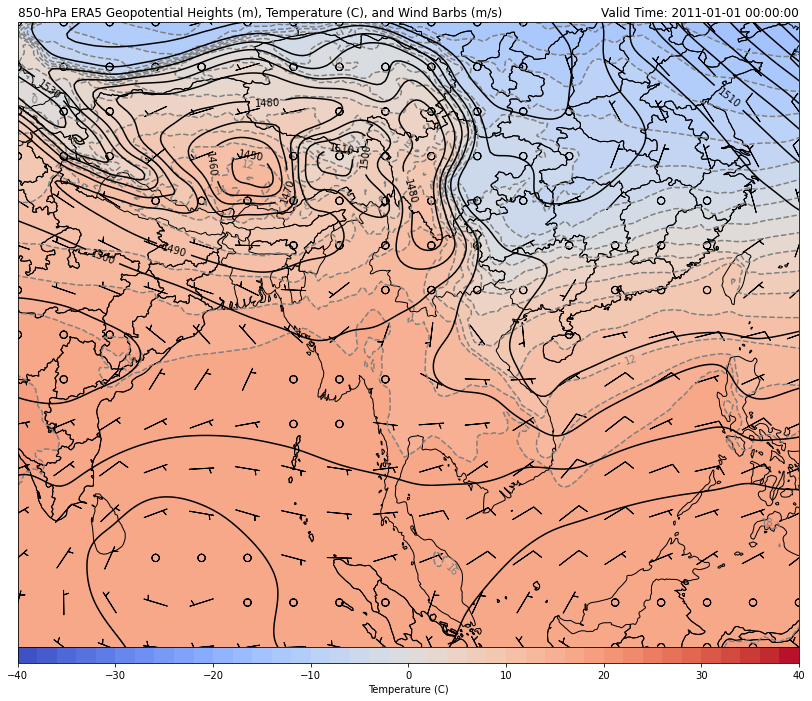

In [13]:
# กำหนดค่าเส้นโครงแผนที่
mapcrs = ccrs.PlateCarree(central_longitude=100)

# กำหนดค่าเส้นโครงแผนที่ของข้อมูล
datacrs = ccrs.PlateCarree()

# ตั้งค่ารูปภาพ figure และสร้าง plot axes ด้วยการกำหนดเส้นโครงแผนที่
fig = plt.figure(1, figsize=(14, 12))
ax = plt.subplot(111, projection=mapcrs)
ax.set_extent([75, 125, 0, 40], ccrs.PlateCarree())

# เพิ่มขอบเขตการปกครอง
ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax.add_feature(cfeature.STATES.with_scale('50m'))

# พลอตอุณหภูมิ ด้วย conlofill และ dashed countour ลมระดับ 850 hPa หน่วยเซลเซียส
clevs_850_tmpc = np.arange(-40, 41, 2)
cf = ax.contourf(lons, lats, tmpc_850, clevs_850_tmpc, cmap=plt.cm.coolwarm,
                 transform=datacrs)
cb = plt.colorbar(cf, orientation='horizontal', pad=0, aspect=50)
cb.set_label('Temperature (C)')
csf = ax.contour(lons, lats, tmpc_850, clevs_850_tmpc, colors='grey',
                 linestyles='dashed', transform=datacrs)
plt.clabel(csf, fmt='%d')


# พลอตค่า 850-hPa Geopotential Heights หน่วยเมตร
clevs_850_hght = np.arange(0, 2000, 10)
cs = ax.contour(lons, lats, hght_850, clevs_850_hght, colors='black',
                transform=datacrs)
plt.clabel(cs, fmt='%d')

# พลอต 850-hPa wind barbs หน่วยนอต, และทำการ regrid เพื่อลดจำนวน barbs
ax.barbs(lons, lats, uwnd_850, vwnd_850, pivot='middle',
         color='black', regrid_shape=15, transform=datacrs)  #ทดลองเปลี่ยน 10 เป็น 20 
 
# เพิ่มชื่อพลอตทางด้านขวาและซ้าย
plt.title('850-hPa ERA5 Geopotential Heights (m), Temperature (C),'
          ' and Wind Barbs (m/s)', loc='left')
plt.title('Valid Time: {}'.format(vtime), loc='right')

# ปรับภาพและแสดงผล
plt.subplots_adjust(bottom=0, top=1)
plt.show()

## พลอตเชิงภูมิอากาศวิทยา 

In [14]:
df = xr.open_dataset('era5_monthly_mean_globe.nc')

In [15]:
# เลือกโดยใช้วิธีการ groups ใน xarray เอาเฉพาะเดือนมาก่อน เพื่อให้ได้ index เดือนมา
month_idxs=df.groupby('time.month').groups
# สกัดค่า index ของเดือนที่ต้องการ ในที่นี้ใช้ 7 แทนเดือนกรกฏาคม เนื่องจาก 1 คือเดือนมกราคม
jan_idxs=month_idxs[1]
# เมื่อได้ค่า index ของเดือนกรกฎาคม ให้นำมาใช้สกัดข้อมูลเดือนกรกฎาคมได้เลย
ds_jan=df.isel(time=jan_idxs)

#### กรองเฉพาะเดือนมกราคม

In [16]:
ds_jan

<xarray.Dataset>
Dimensions:    (longitude: 1440, latitude: 721, time: 40)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 1981-01-01 1982-01-01 ... 2020-01-01
Data variables:
    z          (time, latitude, longitude) float32 ...
    r          (time, latitude, longitude) float32 ...
    t          (time, latitude, longitude) float32 ...
    u          (time, latitude, longitude) float32 ...
    v          (time, latitude, longitude) float32 ...
    vo         (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2022-04-07 04:35:51 GMT by grib_to_netcdf-2.24.3: /opt/ecmw...

In [17]:
tmpk = ds_jan.t # temperature
hght  = ds_jan.z #geopotential
uwnd = ds_jan.u #zonal wind
vwnd = ds_jan.v #meridional wind

#### กรองเอาเฉพาะ 1991-2020

In [18]:
tmpk = tmpk.loc['1991-01':'2020-01']
hght = hght.loc['1991-01':'2020-01']
uwnd =uwnd.loc['1991-01':'2020-01']
vwnd = vwnd.loc['1991-01':'2020-01']

In [19]:
tmpk.shape

(30, 721, 1440)

In [20]:
tmpk

<xarray.DataArray 't' (time: 30, latitude: 721, longitude: 1440)>
[31147200 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 1991-01-01 1992-01-01 ... 2020-01-01
Attributes:
    units:          K
    long_name:      Temperature
    standard_name:  air_temperature

In [21]:
# หาค่า mean เนื่องจากตอนนี้ข้อมูลเป็นแบบ data array
tmpk = tmpk.mean(axis=0)
hght = hght.mean(axis=0)
uwnd = uwnd.mean(axis=0)
vwnd = vwnd.mean(axis=0)

In [22]:
tmpk.shape

(721, 1440)

In [23]:
# Convert temperatures to degree Celsius for plotting purposes
tmpc_850 = (tmpk  - 273.15) * units.celsius

In [24]:
# Select and grab 850-hPa geopotential heights and wind components, smooth with gaussian_filter
hght_850 = gaussian_filter(hght.data, sigma=3.0)/9.80665  #9.80665 m/s**2 to convert geopotential to geopotential height above geoid
uwnd_850 = gaussian_filter(uwnd.data, sigma=3.0) * units('m/s')
vwnd_850 = gaussian_filter(vwnd.data, sigma=3.0) * units('m/s')

In [25]:
# ใช้ MetPy คำนวณค่าความเร็วลมเพื่อใช้ colorfill plot 
sped_850= mpcalc.wind_speed(uwnd_850, vwnd_850)

In [26]:
hght_850.shape

(721, 1440)

C:\Users\Admin\anaconda3\envs\metpy\lib\site-packages\cartopy\crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
C:\Users\Admin\anaconda3\envs\metpy\lib\site-packages\cartopy\crs.py:836: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_strings = list(multi_line_string)
C:\Users\Admin\anaconda3\envs\metpy\lib\site-packages\cartopy\crs.py:836: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  line_strings = list(multi_line_string)
C:\Users\Admin\anaconda3\envs\metpy\li

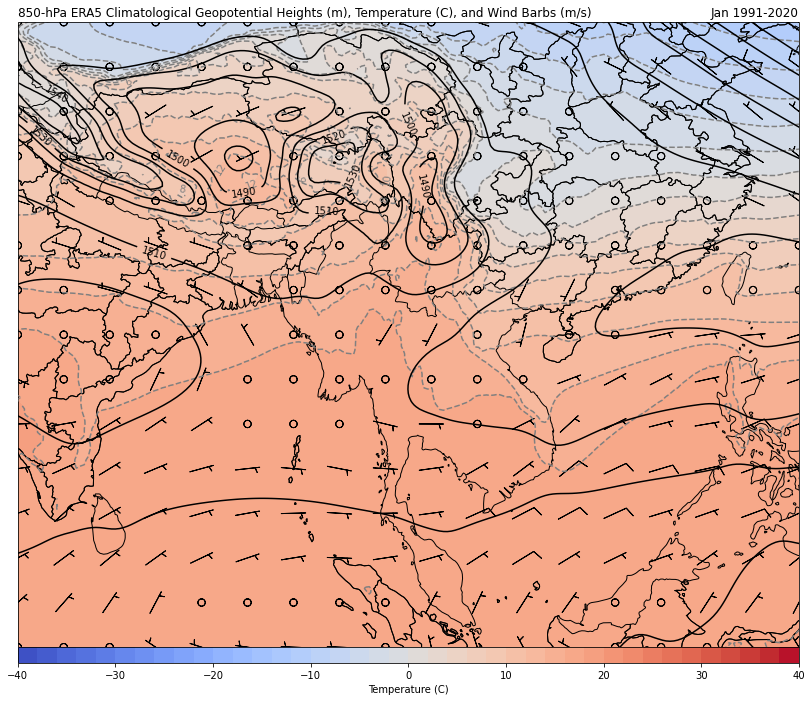

In [27]:
# กำหนดค่าเส้นโครงแผนที่
mapcrs = ccrs.PlateCarree(central_longitude=100)

# กำหนดค่าเส้นโครงแผนที่ของข้อมูล
datacrs = ccrs.PlateCarree()

# ตั้งค่ารูปภาพ figure และสร้าง plot axes ด้วยการกำหนดเส้นโครงแผนที่
fig = plt.figure(1, figsize=(14, 12))
ax = plt.subplot(111, projection=mapcrs)
ax.set_extent([75, 125, 0, 40], ccrs.PlateCarree())

# เพิ่มขอบเขตการปกครอง
ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax.add_feature(cfeature.STATES.with_scale('50m'))

# พลอตอุณหภูมิ ด้วย conlofill และ dashed countour ลมระดับ 850 hPa หน่วยเซลเซียส
clevs_850_tmpc = np.arange(-40, 41, 2)
cf = ax.contourf(lons, lats, tmpc_850, clevs_850_tmpc, cmap=plt.cm.coolwarm,
                 transform=datacrs)
cb = plt.colorbar(cf, orientation='horizontal', pad=0, aspect=50)
cb.set_label('Temperature (C)')
csf = ax.contour(lons, lats, tmpc_850, clevs_850_tmpc, colors='grey',
                 linestyles='dashed', transform=datacrs)
plt.clabel(csf, fmt='%d')


# พลอตค่า 850-hPa Geopotential Heights หน่วยเมตร
clevs_850_hght = np.arange(0, 2000, 10)
cs = ax.contour(lons, lats, hght_850, clevs_850_hght, colors='black',
                transform=datacrs)
plt.clabel(cs, fmt='%d')

# พลอต 850-hPa wind barbs หน่วยนอต, และทำการ regrid เพื่อลดจำนวน barbs
ax.barbs(lons, lats, uwnd_850, vwnd_850, pivot='middle',
         color='black', regrid_shape=15, transform=datacrs)  #ทดลองเปลี่ยน 10 เป็น 20 
 
# เพิ่มชื่อพลอตทางด้านขวาและซ้าย
plt.title('850-hPa ERA5 Climatological Geopotential Heights (m), Temperature (C),'
          ' and Wind Barbs (m/s)', loc='left')
plt.title('Jan 1991-2020', loc='right')

# ปรับภาพและแสดงผล
plt.subplots_adjust(bottom=0, top=1)
plt.show()